<a href="https://colab.research.google.com/github/Debantam-Majilla/Bridgeweave-Assignment/blob/main/Customer_Online_Time_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import warnings                        # To ignore any warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%pylab inline

import os
import pandas as pd
import numpy as np

import glob 
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


**Importing Customer Dataset**


In [3]:
customer=pd.read_csv("/content/sample_data/customers.csv")
print("Shape of customers table :",customer.shape)
print("\n")
print(customer.head())

Shape of customers table : (2500, 4)


       id gender  age  number_of_kids
0  979863   MALE   26               2
1  780123   MALE   60               2
2  614848   MALE   45               4
3  775046   MALE   62               3
4  991601   MALE   23               0


**Checking for any null values.**

-Turns out- No null values .Customer Data is well structured.

In [4]:
customer.isnull().sum()

id                0
gender            0
age               0
number_of_kids    0
dtype: int64

Importing ping dataset 


1.   **Timestamps need to convert to Datetime format.**
2.   **We can segment hour portion from datetime format**
3.   **We can understand On which hour of days, most log-ins happened.**
4.   **We can use No of Logins at past for each id ,to be a feature of our prediction.**



In [52]:
ping=pd.read_csv("/content/sample_data/pings.csv")
print("Shape of customers table :",ping.shape)
print("\n")



Shape of customers table : (19573418, 2)




**Taking No of Log-in per ID as a feature for our model** 

In [53]:
no_logins=ping.groupby(["id"])["timestamp"].count().reset_index()
no_logins.columns=["id","No_Of_Past_logins"]
no_logins

,id,No_Of_Past_logins
0,111556,4276
1,111575,7203
2,111779,3809
3,111839,13560
4,112486,5205
...,...,...
2475,997190,4073
2476,997500,9014
2477,997510,10172
2478,998215,5699


In [8]:
import dateutil.parser
## convert the timestamp to a python date object 
ping['Time'] = list(map(lambda v : datetime.datetime.fromtimestamp(v).strftime('%Y-%m-%d %H:%M:%S'), ping['timestamp']))
ping['times'] = list(map(dateutil.parser.parse, ping['Time']))

ping['hour'] = list(map(lambda v : v.hour, ping['times']))
ping['day'] = list(map(lambda v : v.day, ping['times']))
ping.head()

,id,timestamp,Time,times,hour,day
0,899313,1496278800,2017-06-01 01:00:00,2017-06-01 01:00:00,1,1
1,373017,1496278800,2017-06-01 01:00:00,2017-06-01 01:00:00,1,1
2,798984,1496278800,2017-06-01 01:00:00,2017-06-01 01:00:00,1,1
3,245966,1496278800,2017-06-01 01:00:00,2017-06-01 01:00:00,1,1
4,689783,1496278800,2017-06-01 01:00:00,2017-06-01 01:00:00,1,1


**Below cell is giving us- Mostly users loggedin at 2PM or 3 PM of any day.**

In [9]:
aggregatedData = ping[["hour","day","id"]].groupby(['hour', 'day']).agg(['count'])
    
aggregatedData = aggregatedData.reset_index()
aggregatedData.columns = ['hour','day','app_openings']
aggregatedData

#From this we can understand that users generrally logs in to our app mostly at 2PM or 3 PM

,hour,day,app_openings
0,1,1,54871
1,2,1,119891


**Importing test dataset (supervised dataset)**

In [11]:
test=pd.read_csv("/content/sample_data/test.csv")
test

,id,date,online_hours
0,979863,28/06/17,7
1,979863,27/06/17,9
2,979863,26/06/17,9
3,979863,25/06/17,10
4,979863,24/06/17,9
...,...,...,...
17495,165666,26/06/17,7
17496,165666,25/06/17,7
17497,165666,24/06/17,10
17498,165666,23/06/17,6


**Merging Customer table , Test Table & newly generated No of Log_in table for each ID**

In [54]:
df1=pd.merge(customer,test)

import datetime as dt
df1['Date'] = pd.to_datetime(df1['date'])

final=pd.merge(no_logins,df1).iloc[:,[0,2,3,4,7,1,6]]
final

,id,gender,age,number_of_kids,Date,No_Of_Past_logins,online_hours
0,111556,FEMALE,49,4,1970-01-01 00:00:00.000719163,4276,3
1,111556,FEMALE,49,4,1970-01-01 00:00:00.000719163,4276,3
2,111556,FEMALE,49,4,1970-01-01 00:00:00.000719163,4276,0
3,111556,FEMALE,49,4,1970-01-01 00:00:00.000719163,4276,0
4,111556,FEMALE,49,4,1970-01-01 00:00:00.000719163,4276,0
...,...,...,...,...,...,...,...
17418,998229,MALE,31,0,1970-01-01 00:00:00.000719163,12951,5
17419,998229,MALE,31,0,1970-01-01 00:00:00.000719163,12951,5
17420,998229,MALE,31,0,1970-01-01 00:00:00.000719163,12951,9
17421,998229,MALE,31,0,1970-01-01 00:00:00.000719163,12951,6


In [55]:
final["gender"].value_counts()#.plot(kind="bar")

#Clearly Data is imbalance . Much more Male category than Female category

MALE      13153
FEMALE     4270
Name: gender, dtype: int64

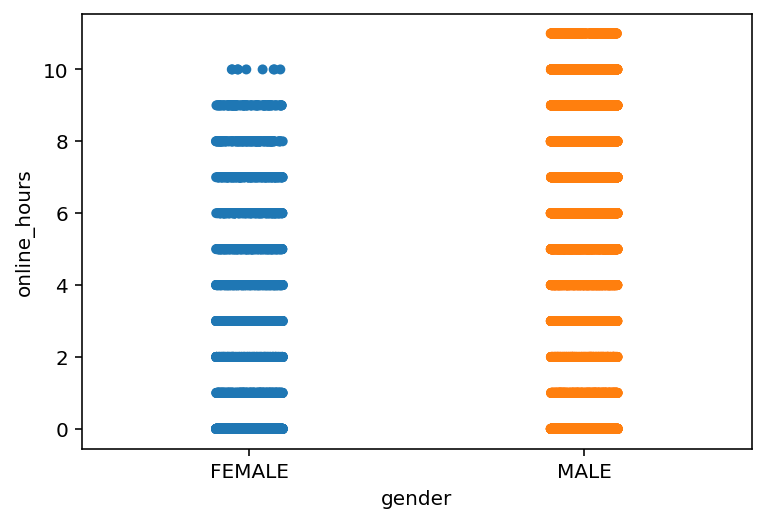

In [56]:
# Similarly MALE having more contibution in Online_hours

sns.stripplot(x="gender",y="online_hours",data=final)

**Fetching X-feature vector & Y- output (online_hours)**

In [57]:
X=final.iloc[:,:-1]
Y=final.iloc[:,6]


**Taking Date as any feature is not a good idea.**
**converting date to numeric values**

In [58]:
X['Date']=X['Date'].map(dt.datetime.toordinal)

#convert gender column to one hot encoding
gender=pd.get_dummies(X["gender"])

# drop gender column 
X.drop("gender",axis=1,inplace=True)

#concat the dummy variables
X=pd.concat([X,gender],axis=1)


from sklearn import preprocessing
X = preprocessing.scale(X)
Y = preprocessing.scale(Y)

In [18]:
#scaled features ( MODEL 1 & MODEL 2)
X

array([[-1.75168298e+00,  9.45541566e-01,  1.67726950e+00, ...,
        -2.71768915e-04,  1.84130128e+00, -1.84130128e+00],
       [-1.75168298e+00,  9.45541566e-01,  1.67726950e+00, ...,
        -2.71768915e-04,  1.84130128e+00, -1.84130128e+00],
       [-1.75168298e+00,  9.45541566e-01,  1.67726950e+00, ...,
        -2.71768915e-04,  1.84130128e+00, -1.84130128e+00],
       ...,
       [ 1.68734024e+00,  1.79189775e+00,  1.03281010e+00, ...,
         3.64397441e-01, -5.43094176e-01,  5.43094176e-01],
       [ 1.68734024e+00,  1.79189775e+00,  1.03281010e+00, ...,
         3.64397441e-01, -5.43094176e-01,  5.43094176e-01],
       [ 1.68734024e+00,  1.79189775e+00,  1.03281010e+00, ...,
         3.64397441e-01, -5.43094176e-01,  5.43094176e-01]])

**MODEL 1 : Multiple linear Regression**

**Data used : Customers + Feature generated from Pings+ test table**

**-  R-Squre Error of our model prediction is less than desired.**

**-  RMSE is also can be improved.**


In [59]:
# MODEL 1


# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

# Fitting Multiple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
model1 = LinearRegression()
model1.fit(X_train, y_train)

# Predicting the Test set results
y_pred = model1.predict(X_test)

from sklearn.metrics import r2_score
score=r2_score(y_test,y_pred)
print("R-SQURE ERROR IS :",score)

from sklearn.metrics import mean_squared_error
rms = mean_squared_error(y_test,y_pred, squared=False)
print("RMS ERROR IS ",rms)

R-SQURE ERROR IS : 0.432723136286818
RMS ERROR IS  0.7488773358837842


**MODEL 2 : Huber Regression**

**Data used : Customers + Feature generated from Pings+ test table**

**-  R-Squre Error improved**

**-  RMSE is also improved a bit**

**Huber Regression is a Robust version of Regression Technique which is more Robust to Outliars.**

In [60]:
# MODEL 2


from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

from sklearn.linear_model import (LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

 
# define the model
model2 = HuberRegressor()

model2.fit(X_train, y_train)

# Predicting the Test set results
y_pred = model2.predict(X_test)

from sklearn.metrics import r2_score
score=r2_score(y_test,y_pred)
print("R-SQURE ERROR IS :",score)

from sklearn.metrics import mean_squared_error
rms = mean_squared_error(y_test,y_pred, squared=False)
print("RMS ERROR IS ",rms)

R-SQURE ERROR IS : 0.42532489924145966
RMS ERROR IS  0.7537448223951649


Model 3 : Only used test data as input to our model. 

- I am unable to understand given problem statement , that our model will evaluate Online_hours given Only Id & Date as feature.
- If that is the case, what is the use of Pings & Curtomer table.
- I am slight confuse at that issue. Thus creating different model for different use case.

**Model 1 & Model 2 , if test data contains ID,gender,age,no_of_kids , date & No_login ( from Pings data) as input feature & online_hours as Output feture.**

**Model 3 : when ID,Date is input feature & Online_hours as output feature.**

In [61]:
#Model 3


test['date']=pd.to_datetime(test['date'])
test['date']=test['date'].map(dt.datetime.toordinal)

X=test.iloc[:,[0,1]]
Y=test.iloc[:,:-1]

from sklearn import preprocessing
X = preprocessing.scale(X)
Y = preprocessing.scale(Y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1)

# Fitting Multiple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
model3 = LinearRegression()
model3.fit(X_train, y_train)

# Predicting the Test set results
y_pred = model3.predict(X_test)

from sklearn.metrics import r2_score
score=r2_score(y_test,y_pred)
print("R-SQURE ERROR IS :",score)

from sklearn.metrics import mean_squared_error
rms = mean_squared_error(y_test,y_pred, squared=False)
print("RMS ERROR IS ",rms)


R-SQURE ERROR IS : 1.0
RMS ERROR IS  1.5648257758426741e-16
